In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split as tts
import joblib
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00603/in-vehicle-coupon-recommendation.csv")
# df = df.sample(frac=1)
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [3]:
df.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
df.isnull().sum()

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64

In [5]:
df = df.drop('car',axis=1)
for col in df.columns:
    df[col] = df[col].fillna(df[col].mode()[0])

df.isnull().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ5min        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

# 75:25 Train-Test split and TSNE plot

In [6]:
df = pd.get_dummies(df,columns=df.select_dtypes('object').columns)
data = np.array(df.drop('Y',axis=1))
labels =np.array( df.Y)
X_train, X_test, y_train, y_test = tts(data, labels, test_size=0.25,random_state=42)


In [7]:
tsne_1 = TSNE(n_components=2).fit_transform(data)
tsne_1 = pd.DataFrame(tsne_1)
tsne_1['Y'] = labels

Text(0.5, 1.0, 'TSNE plot')

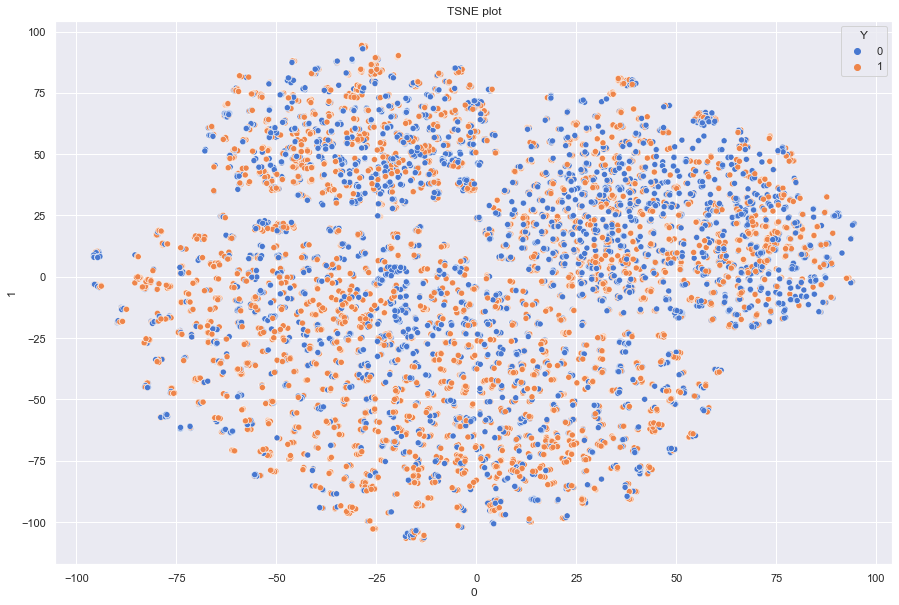

In [8]:
sns.set(rc={'figure.figsize':(15,10)})
sns.scatterplot(x=tsne_1[0],y=tsne_1[1],hue=tsne_1['Y'],palette='muted')
plt.title('TSNE plot')

# KNN implementation with options to use distance as weights, and different p values for minkowski distance

In [9]:
class KNN(object):

    def __init__(self,k,p,weights):
        """k is the number of neighbours to consider,

        p is the order of minkowski distance,

        weights takes 'uniform' or 'distance' as parameters"""
        super(KNN, self).__init__()
        
        self.k,self.p,self.weights = k,p,weights

        
    def fit(self,X,y):
        self.X_train = X
        self.y_train = y


    def predict(self,X):
        dist = cdist(X,self.X_train,'minkowski',int(self.p))
        dist =np.clip(dist,1e-16,np.amax(dist))
        ele=np.argpartition(dist,self.k)
        idx = ele[:,:self.k]
        nearestLabels = y_train[idx]
        if self.weights == 'uniform':
            modes = np.array(stats.mode(nearestLabels,axis=1)[0])
            modes = modes.reshape((modes.shape[0]))
            return modes
        else:
            idist = 1/dist
            ypred = []
            for i in range(nearestLabels.shape[0]):
                nn = idist[i][idx[i]]
                sum1,sum0 = 0,0
                for j in range(nearestLabels.shape[1]):
                    if nearestLabels[i][j] == 1:
                        sum1+=nn[j]
                    else:
                        sum0+=nn[j]
                if sum1>=sum0:
                    ypred.append(1)
                else:
                    ypred.append(0)
            return np.array(ypred)

    def score(self,X,y):
        yPred =  self.predict(X)
        return (y==yPred).sum()/len(y)

In [10]:
clf = KNN(5,2,'uniform')
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.6654052349416588

In [11]:
clf.score(X_train,y_train)

0.7778828970881951

# Grid Search on k

## with "distance" as weight and p=2
### Optimal number of neighbours is: 35, and accuracy obtained is 0.7139703563544623

In [12]:
K = np.arange(1,50,2)
records = []
for k in K:
    clf = KNN(k,2,'distance')
    clf.fit(X_train,y_train)
    s = clf.score(X_test,y_test)
    records.append([k,s])
    
records = np.array(records)
np.argmax(records[:,1])

17

In [13]:
opt_k = int(records[np.argmax(records[:,1])][0])
acc = records[np.argmax(records[:,1])][1]
print(f"Optimal value of k is: {opt_k}, and accuracy obtained is {acc}")


Optimal value of k is: 35, and accuracy obtained is 0.7139703563544623


### error vs number of neighbours graph

<AxesSubplot:xlabel='number of nearest neighbours', ylabel='loss'>

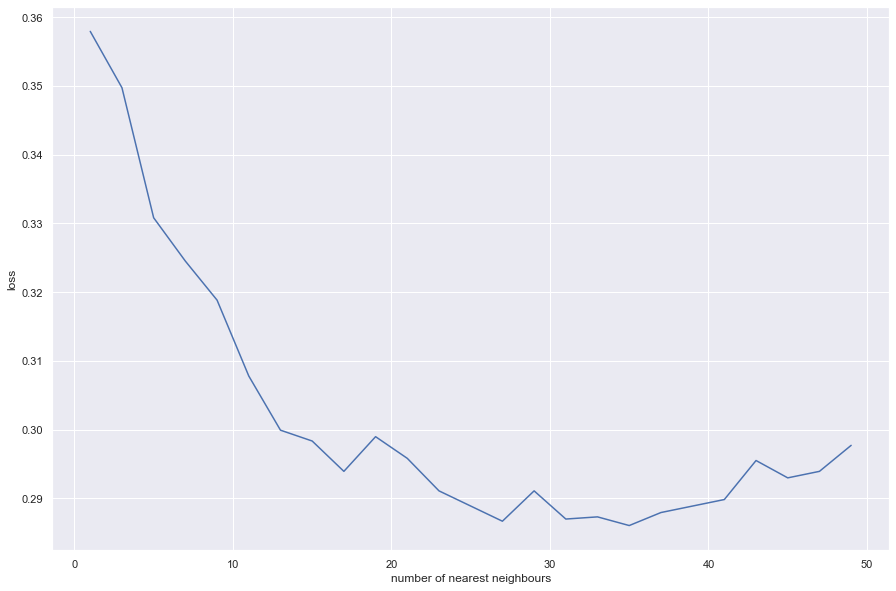

In [14]:
plt.xlabel("number of nearest neighbours")
plt.ylabel("loss")
sns.lineplot(x=records[:,0],y=1-records[:,1])

# sklearn KNN fit using optimal number of neighbours
### accuracy obtained: 0.7139703563544623
### No difference in accuracy obtained with both the methods

In [15]:
neigh = KNeighborsClassifier(n_neighbors=opt_k,p=2,weights='distance')
neigh.fit(X_train, y_train)
neigh.score(X_test,y_test)

0.7139703563544623

## with uniform weight and p=2
### Optimal number of neighbours is: 27, and accuracy obtained is 0.7029328287606433

In [16]:
K = np.arange(1,50,2)
records = []
for k in K:
    clf = KNN(k,2,'uniform')
    clf.fit(X_train,y_train)
    s = clf.score(X_test,y_test)
    records.append([k,s])
    
records = np.array(records)
np.argmax(records[:,1])

13

In [17]:
opt_k = int(records[np.argmax(records[:,1])][0])
acc = records[np.argmax(records[:,1])][1]
print(f"Optimal value of k is: {opt_k}, and accuracy obtained is {acc}")

Optimal value of k is: 27, and accuracy obtained is 0.7029328287606433


<AxesSubplot:xlabel='number of nearest neighbours', ylabel='loss'>

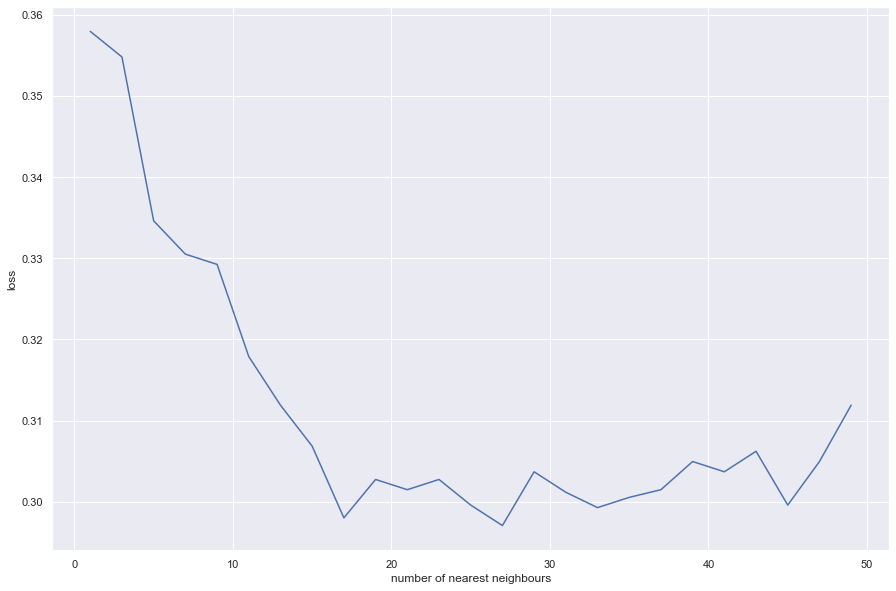

In [18]:
plt.xlabel("number of nearest neighbours")
plt.ylabel("loss")
sns.lineplot(x=records[:,0],y=1-records[:,1])

# sklearn KNN fit using optimal number of neighbours
### accuracy obtained: 0.7029328287606433
### No difference in accuracy obtained with both the methods

In [19]:
neigh = KNeighborsClassifier(n_neighbors=opt_k,p=2,weights='uniform')
neigh.fit(X_train, y_train)
neigh.score(X_test,y_test)

0.7029328287606433